# Using label Propagation pipeline to label and classify mock data

This notebook demonstrate how to use the label propagation code to label clothing data. The data used in this example is a Mock dataset randomly generated using the most common words for each category in the actual data used in the paper that accompanies this work. 

This work is intended to give a demonstration of the methods and code used in this work. As it is a mock dataset with product name that are not alway realistic we do not expect the results to be as accurate as those reported in the paper.

In [1]:
# Python imports
import json
import numpy as np
import pandas as pd
from importlib import reload
import logging
import  sys

# plotting imports
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib notebook

# scikit lean imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

# NLP imports
from fuzzywuzzy import fuzz
from nltk.metrics import distance

# Custom imports of files to run label propagation pipeline
from src import labelling_pipeline
from src import Word_vectors

logging.basicConfig(stream=sys.stdout, level=logging.INFO)

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

logging.getLogger("gensim").setLevel(logging.CRITICAL)


/home/hazel/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


*Note about the above warning: this work was undertaken using diffLib not python-Levenshtein due to restriction on avalible packages. To use python-levenshtein adjustments to the thresholds may be required*

### Read in data

In this code example we make use of a mock dataset and seed labels which are styled on the data in the accompying paper, see section 2

First read in the seed labels that will be used for fuzzy matching and label propagation

In [2]:
# seed labels
with open('data/seed_labels.json', 'r') as f:
    seed_labels = json.load(f)

Now read in the mock data to be labelled 

In [3]:
# Read in data
df_mock = pd.read_csv('data/clothing_mock_data.csv',
                      encoding="ISO-8859-1")

Prevelance of items in the mock dataset

In [4]:
print('Number of items for each label')
for lab in np.sort(df_mock.true_label.unique()):
    print(
        f"{len(df_mock[df_mock['true_label'] == lab])} items with label {lab} "
    )

Number of items for each label
1104 items with label 0 
434 items with label 1 
393 items with label 2 
75 items with label 3 
576 items with label 4 
514 items with label 5 
395 items with label 6 
243 items with label 7 
261 items with label 8 


### Create a test train split
In the paper we had a mock 2 months of data for the test and train datasets. Here as the mock data is smaller we will use a test train split stratified on the true label. There is an 80/20% train/test split in this mock example.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df_mock.drop('true_label', axis=1),
                                                    df_mock['true_label'], test_size=0.20,
                                                    stratify=df_mock['true_label'])

### Helper lists 

These are some helper lists that are used in the rest of this notebook.
These are lists of the primary gender and high level category for each category and a custom stopword list. 
The final helper list is of the category names. 
The method performs label propagation in a one vs rest mode for each category in turn. Each run through will be stored in a dictionary  of dataframes with key corresponding to outs. 

The stop words will be removed before creating the word vectors.

The division and categories lists are used to help with selecting sub-set to match with and to clean the fuzzy matching to ensure maximum accuracy for the labels going into label propagation.

In [6]:
# gender for each category
divisions = ['Womens', 'Men', 'Womens', 'Womens', 'Boys', 'Girls', 'Men', 'Men']
# broad categories for fuzzy matching cleaning
categories = ['Coats', 'Shirts', 'Fitness & activewear', 'Swim', 'Jeans',
              'Tops', 'Underwear', 'Underwear']

# list of stopwords for use in word vectors
stop = ['pack', 'print', 'printed', 'sleeve', 'long', 'fit',
        'f', 't', 's', 'asos', 'stripe', 'slim', 'running', 'active']

# names for output cleaned/labeled dataframes
outs = ['coats', 'shirts', 'shorts', 'swim', 'jeans', 'tops', 'pants', 'socks']

# Perform Label propogation for each category in turn 


These are the parameters used for fuzzy matching. 

## Method parameters

Each matching method used requires a dictionary of the require parameters.
These are put into a list to allow parameters for different methods to be run in the pipeline.

The final fuzzy matched class for an is a popular vote decision from the result of all the methods used.
In the version used in the paper and match is excepted if 2 of 3 metrics agree, positively or negatively. 
See section 3.2.1 for details of the fuzz matching methods used in this work

In [7]:
matching_list = [{
    "label": "label_fuz",
    "func": fuzz.partial_ratio,
    "thresh": 70,
    "neg": 25,
    "greater": True,
    "less": False}, 
    {
    "label": "label_edit",
    "func": distance.edit_distance,
    "thresh": 30,
    "neg": 75,
    "greater": False,
    "less": True}, 
    {
    "label": "label_jaccard",
    "func": distance.jaccard_distance,
    "thresh": 0.30,
    "neg": 0.75,
    "greater": False,
    "less": True}]

Similarly as for the fuzzy matching above there are hyperparameters required for both the word vectors and the label propagation. 

The dictionary below contains first 3 parameters for the word vectorisation methods and then 5 different label propagation parameters.

In [8]:
word_labprop_params = {
    "epochs": 200,     
    "print_sim": False,
    "ngram_range": (1, 2),
    "doc2vec_params": {   
        'alpha': 0.01,
        'kernel': 'knn',
        'n_neighbors': 6,
        "thresh": 0.7,
    },
    "tfidf_params": {
        'alpha': 0.01,
        'kernel': 'knn',
        'n_neighbors': 6,
        "thresh": 0.7, 
    },
    "count_params": {
        "alpha": 0.01,
        "kernel": "knn",
        "n_neighbors": 6,
        "thresh": 0.7,  
    },
    "fast_params": {
        "alpha": 0.01,
        "kernel": "knn",
        "n_neighbors": 6,
        "thresh": 0.7,
    },
    "word2vec_params": {
        "alpha": 0.01,
        "kernel": "knn",
        "n_neighbors": 6,
        "thresh": 0.7, 
    }
}

## Run the label propagation loop

Below is the main function performing the label propagation. This loop performs all the methods described in sections 3.1 to 3.2 of the accompanying paper and shown in Figure 5.

As described in the paper the code takes a one vs rest method performing matching and then label propagation for the each category in turn.
The results of each propagation are then stored into a dictionary of dataframes for in order for the results to be combined across all categories.

In [9]:
reload(labelling_pipeline)

# empty dictinary to collect results of each category
clean_frames = dict()

# loop through the labelling pipeline for each output category
for i in range(len(outs)):
    
    logger.info(f"** category: {outs[i]} **")
    
    # select only the correct gender - assume the gender column is reliable
    temp = X_train.loc[(X_train['division'] == divisions[i])]

    # perform matching and cleaning
    cleaned = labelling_pipeline.labelling_pipeline(data=temp, name_col="name",
                                                    matching_params=matching_list,
                                                    word_vectorizer_params=word_labprop_params,
                                                    n_words=15, stop_words=stop, item_id=1,
                                                    label_names=seed_labels[str(i)], 
                                                    common_words=True,
                                                    cat_clean=True, division=divisions[i],
                                                    category=categories[i],
                                                    wv_names=("word2vec", "tfidf", "count"),
                                                    use_difflib=True, notebook=True)
    
    clean_frames[outs[i]] = cleaned

print('labelled')

INFO:__main__:** category: coats **
INFO:src.labelling_pipeline:Using difflib for sequence matching with fuzzywuzzy
INFO:src.labelling_pipeline:Cleaning with common words
INFO:src.labelling_pipeline:size of data after clean with common words: 994
INFO:src.labelling_pipeline:Fuzzy Matching



INFO:src.labelling_pipeline:Number of fuzzyMatch labels: 17
INFO:src.labelling_pipeline:Number of negative labels: 49
INFO:src.labelling_pipeline:Word Vectors


INFO:src.labelling_pipeline:calculated word2vec
INFO:src.labelling_pipeline:calculated tfidf
INFO:src.labelling_pipeline:calculated count

INFO:src.labelling_pipeline:Label propagation


/home/hazel/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/home/hazel/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer



INFO:src.labelling_pipeline:Finding modal labels
INFO:src.labelling_pipeline:More than one method used, finding modal label


/home/hazel/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


INFO:__main__:** category: shirts **
INFO:src.labelling_pipeline:Using difflib for sequence matching with fuzzywuzzy
INFO:src.labelling_pipeline:Cleaning with common words
INFO:src.labelling_pipeline:size of data after clean with common words: 786
INFO:src.labelling_pipeline:Fuzzy Matching



INFO:src.labelling_pipeline:Number of fuzzyMatch labels: 41
INFO:src.labelling_pipeline:Number of negative labels: 29
INFO:src.labelling_pipeline:Word Vectors


INFO:src.labelling_pipeline:calculated word2vec
INFO:src.labelling_pipeline:calculated tfidf
INFO:src.labelling_pipeline:calculated count

INFO:src.labelling_pipeline:Label propagation


/home/hazel/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/home/hazel/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer



INFO:src.labelling_pipeline:Finding modal labels
INFO:src.labelling_pipeline:More than one method used, finding modal label


/home/hazel/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


INFO:__main__:** category: shorts **
INFO:src.labelling_pipeline:Using difflib for sequence matching with fuzzywuzzy
INFO:src.labelling_pipeline:Cleaning with common words
INFO:src.labelling_pipeline:size of data after clean with common words: 994
INFO:src.labelling_pipeline:Fuzzy Matching



INFO:src.labelling_pipeline:Number of fuzzyMatch labels: 11
INFO:src.labelling_pipeline:Number of negative labels: 33
INFO:src.labelling_pipeline:Word Vectors


INFO:src.labelling_pipeline:calculated word2vec
INFO:src.labelling_pipeline:calculated tfidf
INFO:src.labelling_pipeline:calculated count

INFO:src.labelling_pipeline:Label propagation


/home/hazel/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/home/hazel/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer



INFO:src.labelling_pipeline:Finding modal labels
INFO:src.labelling_pipeline:More than one method used, finding modal label


/home/hazel/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


INFO:__main__:** category: swim **
INFO:src.labelling_pipeline:Using difflib for sequence matching with fuzzywuzzy
INFO:src.labelling_pipeline:Cleaning with common words
INFO:src.labelling_pipeline:size of data after clean with common words: 994
INFO:src.labelling_pipeline:Fuzzy Matching



INFO:src.labelling_pipeline:Number of fuzzyMatch labels: 216
INFO:src.labelling_pipeline:Number of negative labels: 64
INFO:src.labelling_pipeline:Word Vectors


INFO:src.labelling_pipeline:calculated word2vec
INFO:src.labelling_pipeline:calculated tfidf
INFO:src.labelling_pipeline:calculated count

INFO:src.labelling_pipeline:Label propagation


/home/hazel/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer



INFO:src.labelling_pipeline:Finding modal labels
INFO:src.labelling_pipeline:More than one method used, finding modal label
INFO:__main__:** category: jeans **
INFO:src.labelling_pipeline:Using difflib for sequence matching with fuzzywuzzy
INFO:src.labelling_pipeline:Cleaning with common words
INFO:src.labelling_pipeline:size of data after clean with common words: 576
INFO:src.labelling_pipeline:Fuzzy Matching



INFO:src.labelling_pipeline:Number of fuzzyMatch labels: 43
INFO:src.labelling_pipeline:Number of negative labels: 12
INFO:src.labelling_pipeline:Word Vectors


INFO:src.labelling_pipeline:calculated word2vec
INFO:src.labelling_pipeline:calculated tfidf
INFO:src.labelling_pipeline:calculated count

INFO:src.labelling_pipeline:Label propagation


/home/hazel/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/home/hazel/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer



INFO:src.labelling_pipeline:Finding modal labels
INFO:src.labelling_pipeline:More than one method used, finding modal label
INFO:__main__:** category: tops **
INFO:src.labelling_pipeline:Using difflib for sequence matching with fuzzywuzzy
INFO:src.labelling_pipeline:Cleaning with common words
INFO:src.labelling_pipeline:size of data after clean with common words: 402
INFO:src.labelling_pipeline:Fuzzy Matching



INFO:src.labelling_pipeline:Number of fuzzyMatch labels: 32
INFO:src.labelling_pipeline:Number of negative labels: 39
INFO:src.labelling_pipeline:Word Vectors


INFO:src.labelling_pipeline:calculated word2vec
INFO:src.labelling_pipeline:calculated tfidf
INFO:src.labelling_pipeline:calculated count

INFO:src.labelling_pipeline:Label propagation



INFO:src.labelling_pipeline:Finding modal labels
INFO:src.labelling_pipeline:More than one method used, finding modal label
INFO:__main__:** category: pants **
INFO:src.labelling_pipeline:Using difflib for sequence matching with fuzzywuzzy
INFO:src.labelling_pipeline:Cleaning with common words
INFO:src.labelling_pipeline:size of data after clean with common words: 786
INFO:src.labelling_pipeline:Fuzzy Matching



INFO:src.labelling_pipeline:Number of fuzzyMatch labels: 33
INFO:src.labelling_pipeline:Number of negative labels: 40
INFO:src.labelling_pipeline:Word Vectors


INFO:src.labelling_pipeline:calculated word2vec
INFO:src.labelling_pipeline:calculated tfidf
INFO:src.labelling_pipeline:calculated count

INFO:src.labelling_pipeline:Label propagation


/home/hazel/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer
/home/hazel/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer



INFO:src.labelling_pipeline:Finding modal labels
INFO:src.labelling_pipeline:More than one method used, finding modal label


/home/hazel/anaconda3/lib/python3.7/site-packages/sklearn/semi_supervised/label_propagation.py:293: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


INFO:__main__:** category: socks **
INFO:src.labelling_pipeline:Using difflib for sequence matching with fuzzywuzzy
INFO:src.labelling_pipeline:Cleaning with common words
INFO:src.labelling_pipeline:size of data after clean with common words: 786
INFO:src.labelling_pipeline:Fuzzy Matching



INFO:src.labelling_pipeline:Number of fuzzyMatch labels: 31
INFO:src.labelling_pipeline:Number of negative labels: 91
INFO:src.labelling_pipeline:Word Vectors


INFO:src.labelling_pipeline:calculated word2vec
INFO:src.labelling_pipeline:calculated tfidf
INFO:src.labelling_pipeline:calculated count

INFO:src.labelling_pipeline:Label propagation



INFO:src.labelling_pipeline:Finding modal labels
INFO:src.labelling_pipeline:More than one method used, finding modal label
labelled


## Combine the labels across iterations 

Once all the one vs rest classifiers have been run we now combine these across all items into a single dataframe containing the propagated labels. 

If the same product is assigned a label in more than one loop it is assigned -1 for unlabelled, as it is propagated label is not certain
If a label is assigned and then a 0 is also assigned the label outranks the 0.
If no label has been assigned ever then we assume the item is junk.


In [10]:
# combine_labels for all categories
label_dict={'other': 0, 'coats': 1, 'shirts': 2, 'shorts': 3, 'swim': 4,
            'jeans': 5, 'tops': 6, 'pants': 7, 'socks': 8}

X_train['label_combined'] = -10000
X_train['lab_count'] = 0 
X_train['zero_count'] = 0

# loop through the categories
for i, frame in enumerate(list(clean_frames.keys())):
    X_train[label_dict[frame]]=np.nan
    index = clean_frames[frame].index
    
    X_train.loc[index, label_dict[frame]] = clean_frames[frame]['label_labprop_mode']
    X_train.loc[(X_train[label_dict[frame]] == 1), 'lab_count'] += 1
    X_train.loc[(X_train[label_dict[frame]] == 0), 'zero_count'] += 1
    
    X_train.loc[(X_train['lab_count']>1), 'label_combined'] = -1
    
    X_train.loc[(X_train[label_dict[frame]] == 1) &
               (X_train['lab_count'] == 1), 'label_combined'] = label_dict[frame]
    X_train.loc[(X_train[label_dict[frame]] == 0) &
               (X_train['zero_count'] == i+1), 'label_combined'] = 0
    X_train.loc[(X_train[label_dict[frame]] == -1) &
               (X_train['lab_count'] == 0), 'label_combined']=-1
    
    X_train.loc[X_train['label_combined'] == -10000, 'label_combined']=0

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


# Examine the results of the label propagation pipeline
These results will not be the same as those given in the paper in section 5 but we use similar methods to examine how well the pipeline has performed 
## Number of labels assigned

In [11]:
print(f'Number of labels assigned: {len(X_train[X_train.label_combined>-1])}')
print(f'Number of unlabelled items: {len(X_train[X_train.label_combined==-1])}')

Number of labels assigned: 2642
Number of unlabelled items: 554


## Classification report for labeled items

In [12]:
print(classification_report(y_train.loc[(X_train.label_combined>-1)],
                            X_train.loc[(X_train.label_combined>-1),'label_combined']))

              precision    recall  f1-score   support

           0       0.61      0.76      0.68       681
           1       0.99      0.88      0.93       283
           2       0.81      0.83      0.82       307
           3       0.31      0.64      0.42        59
           4       0.99      0.96      0.98       448
           5       0.98      0.97      0.97       400
           6       0.96      0.50      0.66       251
           7       0.41      0.55      0.47        91
           8       0.58      0.12      0.20       122

    accuracy                           0.78      2642
   macro avg       0.74      0.69      0.68      2642
weighted avg       0.81      0.78      0.78      2642



## Confusion matrix for labeled items

This figure is analogous to figure 6 of the paper

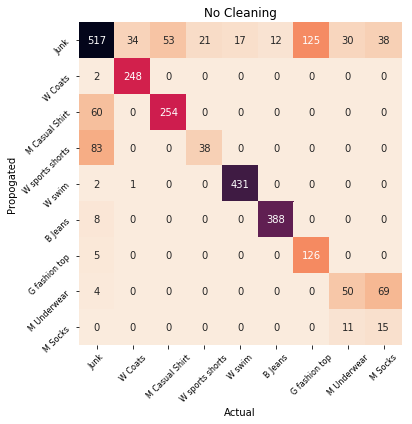

In [13]:
mat = confusion_matrix(y_train.loc[(X_train.label_combined>-1)],
                       X_train.loc[(X_train.label_combined>-1),'label_combined'])
fig,ax=plt.subplots(figsize=(6,6))
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False, cmap=sns.cm.rocket_r)

ax.set_yticklabels(['Junk','W Coats','M Casual Shirt', 'W sports shorts','W swim',
               'B Jeans','G fashion top','M Underwear','M Socks'],rotation=45)

ax.set_xticklabels(['Junk','W Coats','M Casual Shirt', 'W sports shorts','W swim',
               'B Jeans','G fashion top','M Underwear','M Socks'],rotation=45)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

ax.set_title('No Cleaning')
ax.set_xlabel('Actual')
ax.set_ylabel('Propogated')
fig.tight_layout()    

The labels have been propagated accurately for most labels. However propagation has not been as successful for the Mens Socks and Mens Pants categories.
This is likely due to the high level of shared language between socks and underwear as well as them falling in to the same broad category underwear and socks. 
The way the mock data was generated would cause the sharing of language between two categories.
As this is a mock dataset the word order of the product names does not make sense and this may of impacted the quality of the fuzzy matching and the label propagation.

# Train a classifiers

Now we have enough labeled data we can use it to train a classifier. 
In this example notebook we have only used the fastText vectors in the classifier it is straightforward to instead use other word vectors as was done in paper. See sections 3.3 and and 5.3 for further details. 

## Prepare classifier inputs

### Create word vectors
Want to create the word vectors from the largest possible vocabulary so use the whole mock dataset. Here we only use the fasttext vectors, but other vectors could be used.

In [14]:
# get words for word_vectors
names=Word_vectors.remove_stopwords(df_mock['name'])

names
ft_vectors, model_fasttext = Word_vectors.fasttext_vectors(names)
df_mock['fasttext_vec'] = ft_vectors.tolist()




**Infer word vectors for training and test data**

In [15]:
# infer labelled data vectors
names_train=Word_vectors.remove_stopwords(X_train['name'])
X_train['fasttex']=Word_vectors.fasttext_infvec(names_train,model_fasttext).tolist()


# infer unlabelled vectors
names_test=Word_vectors.remove_stopwords(X_test['name'])   
X_test['fasttex']=Word_vectors.fasttext_infvec(names_test,model_fasttext).tolist()


### Create label encodings for the categorical columns
The categorical columns used in this example are division, category and and subcategory 
The encodings are created on the whole test data then applied to test and train

In [16]:
div_code = LabelEncoder().fit(df_mock.division)
cat_code = LabelEncoder().fit(df_mock.category)
subcat_code = LabelEncoder().fit(df_mock.subcategory)

In [17]:
X_train['division_code']=div_code.transform(X_train.division)
X_train['category_code']=cat_code.transform(X_train.category)
X_train['subcategory_code']=subcat_code.transform(X_train.subcategory)


X_test['division_code']=div_code.transform(X_test.division)
X_test['category_code']=cat_code.transform(X_test.category)
X_test['subcategory_code']=subcat_code.transform(X_test.subcategory)



### Create the training dataset
In training the classifier we want to only train with those products that were assigned a label through label propagation. So here we split the training set again into those with labels from label lpropagation and those that remain unlabeled (have value -1). 

In [18]:
labelled=X_train[X_train['label_combined']>-1]
labelled_y=y_train[X_train['label_combined']>-1]

As the word vectors are an array input sklearn requires that all inputs are array type and so we stack all the feature variables together before passing them through the classification algorithms. 


In [19]:
# Stack X train inputs
X_train_in = np.stack(labelled[['division_code', 'category_code',
                                'subcategory_code']].values)
X_train_in = np.concatenate((X_train_in,np.stack(labelled['fasttex'])),axis=1)


# # stack unlabelled inputs 
X_test_in = np.stack(X_test[['division_code', 'category_code',
                             'subcategory_code']].values)
X_test_in = np.concatenate((X_test_in,np.stack(X_test['fasttex'])),axis=1)


## Decision Tree

Build a decision tree with the fastText vectors. No rigorous hyper-parameter search has been undertaken only a basic grid search with 5 fold cross validation. See section 3.3.1 for a description of the decision tree. 

Best fit parameters: {'max_depth': 50, 'min_samples_leaf': 10, 'min_samples_split': 5}

*** Training labelled data set against true labels***
              precision    recall  f1-score   support

           0       0.67      0.83      0.74       681
           1       1.00      0.91      0.95       283
           2       0.87      0.84      0.85       307
           3       0.36      0.73      0.48        59
           4       1.00      1.00      1.00       448
           5       1.00      1.00      1.00       400
           6       0.97      0.48      0.64       251
           7       0.36      0.56      0.44        91
           8       0.42      0.04      0.07       122

    accuracy                           0.81      2642
   macro avg       0.74      0.71      0.69      2642
weighted avg       0.83      0.81      0.80      2642


*** Test split of labelled data set ***
              precision    recall  f1-score   support

           0       0.66      0.83      0.74       221
   

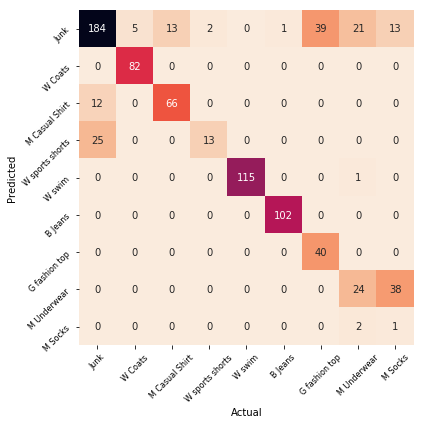

In [20]:
param_grid = [{'max_depth':[5,10,20,30,50],
               'min_samples_leaf':[5,10,15,20,25],
               'min_samples_split':[2,5,7,10,20]}]
dt_clf = GridSearchCV(estimator= DecisionTreeClassifier(class_weight='balanced'),
                      param_grid=param_grid,cv=5)
dt_clf.fit(X_train_in,labelled['label_combined'])

dt_params = dt_clf.best_params_

print(f'Best fit parameters: {dt_params}')

dt_clf = DecisionTreeClassifier(**dt_params)
dt_clf.fit(X_train_in,labelled['label_combined'])

ind = np.argsort(dt_clf.feature_importances_)[::-1]

print('\n*** Training labelled data set against true labels***')

print(classification_report(labelled_y,dt_clf.predict(X_train_in)))


predict_dt=dt_clf.predict(X_test_in)
print('\n*** Test split of labelled data set ***')
print(classification_report(y_test,predict_dt))

mat = confusion_matrix(y_test,predict_dt)
fig,ax=plt.subplots(figsize=(6,6))
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,cmap=sns.cm.rocket_r)
ax.set_yticklabels(['Junk','W Coats','M Casual Shirt', 
                    'W sports shorts','W swim',
                    'B Jeans','G fashion top','M Underwear',
                    'M Socks'],rotation=45)

ax.set_xticklabels(['Junk','W Coats','M Casual Shirt',
                    'W sports shorts','W swim',
                    'B Jeans','G fashion top','M Underwear',
                    'M Socks'],rotation=45)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
fig.tight_layout()


The decision tree works reasonably well with the poorly performing items being the same as those that did not perform so well in propagation. There are some products that are being classified to categories when they are actually junk. As precision is important for the use case of this work then this would need to be further explored if this was not a mock dataset.

## Random Forest

Build a random forest with the fastText vectors. No rigorous hyper-parameter search has been undertaken only a basic grid search with 5 fold cross validation. See section 3.3.2 of the paper for discussion of the random forest.

/home/hazel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best fit parameters: {'max_depth': 50, 'min_samples_leaf': 10, 'min_samples_split': 5}

*** Training labelled data set against true labels***
              precision    recall  f1-score   support

           0       0.87      0.77      0.82       681
           1       1.00      1.00      1.00       283
           2       0.85      0.98      0.91       307
           3       0.36      0.98      0.53        59
           4       1.00      1.00      1.00       448
           5       1.00      1.00      1.00       400
           6       0.98      0.73      0.83       251
           7       0.41      0.80      0.55        91
           8       0.53      0.16      0.25       122

    accuracy                           0.87      2642
   macro avg       0.78      0.82      0.77      2642
weighted avg       0.89      0.87      0.87      2642


*** Test split of labelled data set ***
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       221
   

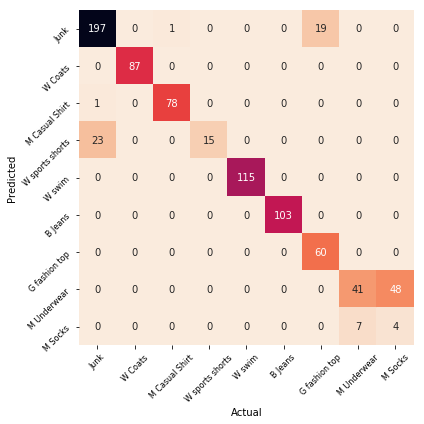

In [21]:
param_grid = [{'n_estimators':[5,10,20,30,50],
               'max_depth':[5,10,20,30,50,100],
               'min_samples_leaf':[1,3,5,10,15]}]
rf_clf = GridSearchCV(estimator= RandomForestClassifier(class_weight='balanced'),
                      param_grid=param_grid,cv=5)
rf_clf.fit(X_train_in,labelled['label_combined'])
rf_parm = rf_clf.best_params_

print(f'Best fit parameters: {dt_params}')

rf_clf = RandomForestClassifier(**rf_parm,class_weight='balanced')
rf_clf.fit(X_train_in,labelled['label_combined'])


print('\n*** Training labelled data set against true labels***')
print(classification_report(labelled_y,rf_clf.predict(X_train_in)))


predict_rf=rf_clf.predict(X_test_in)
print('\n*** Test split of labelled data set ***')
print(classification_report(y_test,predict_rf))

mat = confusion_matrix(y_test,predict_rf)
fig,ax=plt.subplots(figsize=(6,6))
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,cmap=sns.cm.rocket_r)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

predict_rf=rf_clf.predict(X_test_in)

ax.set_yticklabels(['Junk','W Coats','M Casual Shirt', 
                    'W sports shorts','W swim',
                    'B Jeans','G fashion top','M Underwear',
                    'M Socks'],rotation=45)

ax.set_xticklabels(['Junk','W Coats','M Casual Shirt', 
                    'W sports shorts','W swim',
                    'B Jeans','G fashion top','M Underwear',
                    'M Socks'],rotation=45)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
fig.tight_layout()


The random forest is performing better across most categories but is still unable to distinguish socks and underwear. Again this is where the label propagation performed worse. The random forest has significantly improved precision which is desirable for our use case of price statistics. 

## Suport vector machine

Build a SVM with the fastText vectors. No rigorous hyper-parameter search has been undertaken only a basic grid search with 5 fold cross validation. For discussion of the SVM method see section 3.3.3 of the paper.

In [22]:
param_grid = [{'C':[100,500,5000,10000],
               'gamma':[0.0001,0.01,0.1],
               'kernel':['rbf']}]

svm_clf = GridSearchCV(estimator=SVC(probability=True),param_grid=param_grid,cv=5)
svm_clf.fit(X_train_in,labelled['label_combined'])
svm_param = svm_clf.best_params_

Best fit parameters: {'C': 10000, 'gamma': 0.0001, 'kernel': 'rbf'}

*** Training labelled data set against true labels***


/home/hazel/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.78      0.89      0.84       681
           1       1.00      1.00      1.00       283
           2       0.99      1.00      1.00       307
           3       0.46      1.00      0.63        59
           4       1.00      1.00      1.00       448
           5       1.00      1.00      1.00       400
           6       1.00      0.34      0.51       251
           7       0.43      0.99      0.60        91
           8       0.00      0.00      0.00       122

    accuracy                           0.86      2642
   macro avg       0.74      0.80      0.73      2642
weighted avg       0.86      0.86      0.84      2642


*** Test split of labelled data set ***
              precision    recall  f1-score   support

           0       0.78      0.92      0.84       221
           1       1.00      1.00      1.00        87
           2       1.00      1.00      1.00        79
           3       0.47      1.00    

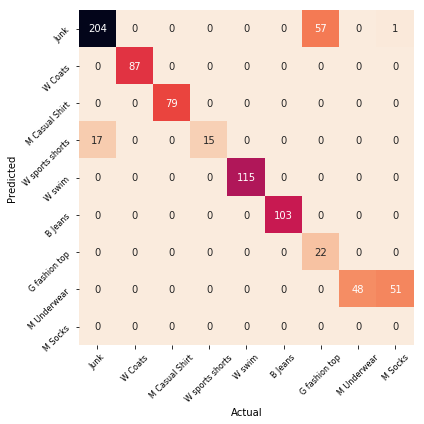

In [23]:
print(f"Best fit parameters: {svm_param}")

svm_clf = SVC(**svm_param, probability=True) 
svm_clf.fit(X_train_in,labelled['label_combined'])

predict_svm=svm_clf.predict(X_test_in)

print('\n*** Training labelled data set against true labels***')
print(classification_report(labelled_y,svm_clf.predict(X_train_in)))

print('\n*** Test split of labelled data set ***')
print(classification_report(y_test,predict_svm))

mat = confusion_matrix(y_test,predict_svm)
fig,ax=plt.subplots(figsize=(6,6))
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False,cmap=sns.cm.rocket_r)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

predict_proba=svm_clf.predict_proba(X_test_in)


ax.set_yticklabels(['Junk','W Coats','M Casual Shirt',
                    'W sports shorts','W swim',
                    'B Jeans','G fashion top','M Underwear',
                    'M Socks'],rotation=45)

ax.set_xticklabels(['Junk','W Coats','M Casual Shirt',
                    'W sports shorts','W swim',
                    'B Jeans','G fashion top','M Underwear',
                    'M Socks'],rotation=45)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
fig.tight_layout()

The SVM has given similar results to the decision tree, performing well except where the label propagation has done poorly. In addition to the mens underwear and socks the girls fashion tops are not working as well. This is also a poorly performing category in label propagation and no items were correctly assigned to it in training of the SVM algorithm. This again could be a factor of the mock dataset although this is a hard category to classify due to its subjective nature. 

All of the classification algorithms are performing well with the labels from label propagation, this is in line with what was found in section 5.3.


# Summary

Although we are using a mock dataset which does not contain product names that entirely make sense we see generally similar trends as with the true data.
The labels obtained from label propagation are sufficiently accurate that they can be used to train a classifier for use on an unseen dataset with promising results.

This notebook is intended to demonstrate the methods of paper Semi-supervised machine learning with word embedding for classification in price statistics, Martindale et.al. using a mock dataset.
We are not attempting to recreate the results of the paper as we can not make the data publicly available instead the mock dataset gives a demonstration of the code used in that work. 